# PIRNN for Modeling a Two-Spherical-Tank System


## Initial Setup


In [1]:
import os

import numpy as np
import torch

import config as cf
from lib.utils import enable_optimizations

enable_optimizations()

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

# Set variable types
dtype = torch.float32
torch.set_default_dtype(dtype)

# Set files folders and names
model_name = "pirnn"
model_path = f"{cf.results_folder}{model_name}.pytorch"
onnx_model_path = f"{cf.results_folder}{model_name}.onnx"
benchmark_path = f"{cf.results_folder}{model_name}-benchmark.hkl"


## Build the PIRNN


### 1. Generate training data


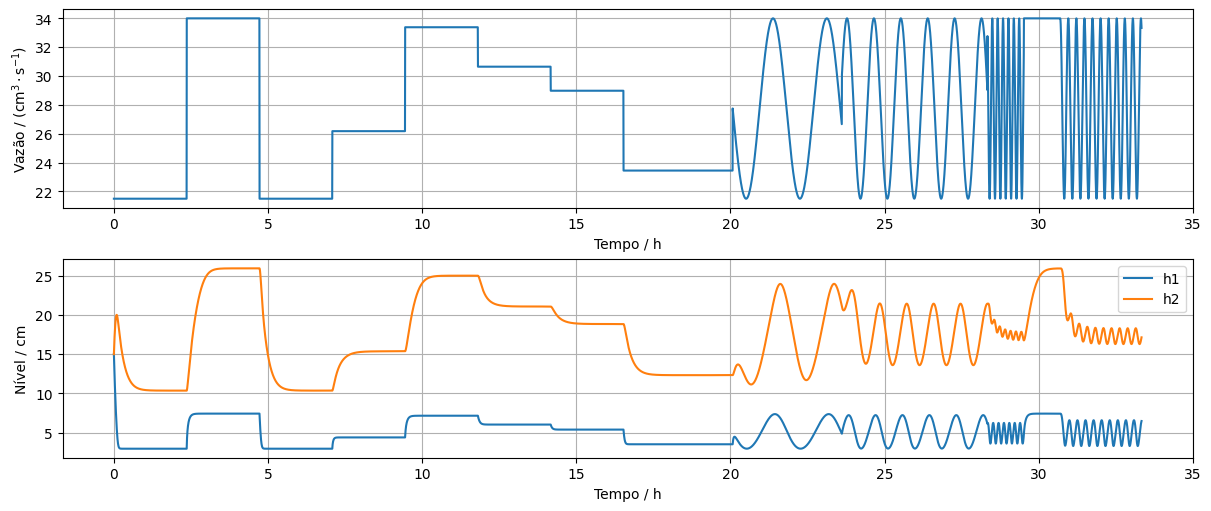

In [2]:
from typing import Any

from lib.common_plots import plot_flow_and_level, plot_tanks
from lib.physical_systems import Spherical_tanks

tanks = Spherical_tanks()
q_min = 21.5
q_max = 34.0

random_q_array = np.random.uniform(q_min, q_max, size=12)


def q_train(t, op: Any = np):
    spacing = 8500
    output = op.ones_like(t) * q_min
    output = op.where(t >= 1 * spacing, q_max, output)
    output = op.where(t >= 2 * spacing, q_min, output)
    output = op.where(t >= 3 * spacing, random_q_array[0], output)
    output = op.where(t >= 4 * spacing, random_q_array[1], output)
    output = op.where(t >= 5 * spacing, random_q_array[2], output)
    output = op.where(t >= 6 * spacing, random_q_array[3], output)
    output = op.where(t >= 7 * spacing, random_q_array[4], output)
    output = op.where(t >= 8 * spacing, random_q_array[5], output)
    output = op.where(
        t >= 8.5 * spacing,
        op.sin(t / 1000) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(
        t >= 10 * spacing,
        op.sin(t / 500) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(
        t >= 12 * spacing,
        op.sin(t / 100) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(t >= 12.5 * spacing, q_max, output)
    output = op.where(
        t >= 13 * spacing,
        op.sin(t / 150) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )

    return output


tanks.set_simulation_parameters(q_train, (0, 120000), 120000 // 10, y0=[15, 15])
h_cas = tanks.simulate_casadi("rk")

h1_cas, h2_cas = torch.tensor(h_cas, dtype=dtype)
q_train_tensor = torch.tensor(q_train(tanks.t_numpy), dtype=dtype)

plot_flow_and_level(tanks.t_numpy, q_train_tensor, h_cas, ["h1", "h2"])


### 2. Manipulates the data to be compatible with the input of an RNN


In [3]:
from lib.utils import prepare_sequences

# Number of historical points provided to the network
history_size = 2

X_true, Y_true = prepare_sequences(
    (h1_cas, h2_cas, q_train_tensor), (h1_cas, h2_cas), history_size
)

# Results
print("X_true shape:", X_true.shape)  # Must be (batch_size, input_size, seq_len)
# print("X_true:", X_true[0:3])
print("Y_true shape:", Y_true.shape)  # Must be (batch_size, output_size)
# print("Y_true:", Y_true[0:3])


X_true shape: torch.Size([11998, 2, 3])
Y_true shape: torch.Size([11998, 2])


### 3. Create the PIRNN


In [4]:
from lib.models import RNN, DataInfo

normalization_data: DataInfo = {
    "in_min": torch.tensor([tanks.h_min, tanks.h_min, q_min], dtype=torch.float32),
    "in_max": torch.tensor([tanks.h_max, tanks.h_max, q_max], dtype=torch.float32),
    "out_min": torch.tensor([tanks.h_min, tanks.h_min], dtype=torch.float32),
    "out_max": torch.tensor([tanks.h_max, tanks.h_max], dtype=torch.float32),
}

model = RNN(3, 32, 2, normalization_data)

with torch.inference_mode():
    print(model(X_true)[:3])
    print(Y_true[:3])


tensor([[14.9339, 12.9970],
        [14.9285, 12.9931],
        [14.9231, 12.9893]])
tensor([[14.2443, 15.6222],
        [13.8788, 15.9153],
        [13.5210, 16.1969]])


### 4. Train the PIRNN


In [5]:
from torch import optim

from lib.common_plots import plot_loss
from lib.utils import mean_square, notify_training_end


def loss_fn(model, _):
    output = model(X_true)

    # Data loss
    h1_true = Y_true[:, 0]
    h2_true = Y_true[:, 1]
    h1_prev = output[:, 0]
    h2_prev = output[:, 1]

    loss_data_h1 = mean_square(h1_true - h1_prev)
    loss_data_h2 = mean_square(h2_true - h2_prev)

    # Loss EDO
    h1_past_true = X_true[:, -1, 0]
    h1_past2_true = X_true[:, -2, 0]

    h2_past_true = X_true[:, -1, 1]
    h2_past2_true = X_true[:, -2, 1]
    q = X_true[:, -1, 2]

    dh1dt_edo, dh2dt_edo = tanks.edo_torch(None, torch.stack([h1_prev, h2_prev]), q)
    # Regressive derivatives with 3 points
    dh1dt_euler = (3 * h1_prev - 4 * h1_past_true + h1_past2_true) / (2 * tanks.dt)
    dh2dt_euler = (3 * h2_prev - 4 * h2_past_true + h2_past2_true) / (2 * tanks.dt)

    loss_edo_h1 = mean_square(dh1dt_edo - dh1dt_euler)
    loss_edo_h2 = mean_square(dh2dt_edo - dh2dt_euler)

    loss_total = loss_data_h1 + loss_data_h2 + loss_edo_h1 + loss_edo_h2
    return loss_total, [
        loss_data_h1.detach(),
        loss_data_h2.detach(),
        loss_edo_h1.detach(),
        loss_edo_h2.detach(),
    ]


if not os.path.exists(model_path):
    print("Unable to retrieve parameters")
    print("Training the model...")
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    history = model.fit(optimizer, loss_fn, 500)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history.extend(model.fit(optimizer, loss_fn, 5000))

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    history.extend(model.fit(optimizer, loss_fn, 5000))

    notify_training_end()

    plot_loss(
        history,
        ["Loss data 1", "Loss data 2", "Loss EDO 1", "Loss EDO 2"],
        "pirnn-train-loss",
    )
    model.eval()
    torch.save(model.state_dict(), model_path)
else:
    print("Retrieving model parameters...")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    print("Parameters recovered. It will not be necessary to rerun the training.")


Retrieving model parameters...
Parameters recovered. It will not be necessary to rerun the training.


### 5. Validate the PIRNN


In [6]:
from lib.predict import predict_torch

random_q_array = np.random.uniform(q_min, q_max, size=18)[::-1]


def q_test(t, op: Any = np):
    spacing = 8500
    output = op.ones_like(t) * q_max
    output = op.where(t >= 0 * spacing, random_q_array[0], output)
    output = op.where(t >= 1 * spacing, random_q_array[1], output)
    output = op.where(t >= 2 * spacing, random_q_array[2], output)
    output = op.where(t >= 3 * spacing, random_q_array[3], output)
    output = op.where(t >= 4 * spacing, random_q_array[4], output)
    output = op.where(t >= 5 * spacing, random_q_array[5], output)
    output = op.where(t >= 6 * spacing, random_q_array[6], output)
    output = op.where(t >= 7 * spacing, random_q_array[7], output)
    output = op.where(t >= 8 * spacing, random_q_array[8], output)
    output = op.where(
        t >= 8.5 * spacing,
        op.sin(t / 2000) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(
        t >= 10 * spacing,
        op.sin(t / 800) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(
        t >= 12 * spacing,
        op.sin(t / 600) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(t >= 12.5 * spacing, q_max, output)
    output = op.where(
        t >= 13 * spacing,
        op.sin(t / 580) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )

    return output


tanks.set_simulation_parameters(q_test, (0, 120000), 120000 // 10, y0=[3, 11])
h_cas = tanks.simulate_casadi("rk")

h1_cas, h2_cas = torch.tensor(h_cas, dtype=dtype)
q_test_tensor = torch.tensor(q_test(tanks.t_numpy), dtype=dtype)

h1_pirnn, h2_pirnn = predict_torch(
    h1_cas, h2_cas, q_test_tensor, model=model, history_size=history_size
)

plot_tanks(
    tanks.t_numpy,
    (h1_cas, h2_cas, h1_pirnn, h2_pirnn),
    ["$h_1$ (CasADi)", "$h_2$ (CasADi)", "$h_1$ (PIRNN)", "$h_2$ (PIRNN)"],
    2,
    "pirnn-test-big",
    "upper right",
)

plot_tanks(
    tanks.t_numpy,
    (h1_cas, h2_cas, h1_pirnn, h2_pirnn),
    ["$h_1$ (CasADi)", "$h_2$ (CasADi)", "$h_1$ (PIRNN)", "$h_2$ (PIRNN)"],
    2,
    "pirnn-test",
    "upper left",
    (5, 3),
)


## Export the PIRNN


In [7]:
import onnxruntime as ort

# Export the PyTorch model params to an txt file (and ...)
with open(f"{cf.results_folder}{model_name}_params.txt", "w") as file:
    state_dict = model.state_dict()
    for name, param in state_dict.items():
        weights = param.numpy()
        dims = weights.shape

        # Converte o numpy array para uma string formatada no estilo C++ sem chaves internas
        if weights.ndim == 1:
            # Vetor 1D
            formatted_weights = "{" + ", ".join(f"{v:.6f}" for v in weights) + "};"
        elif weights.ndim == 2:
            # Matriz 2D
            flattened_weights = (
                weights.flatten()
            )  # Achata a matriz para uma única dimensão
            formatted_weights = (
                "{" + ", ".join(f"{v:.6f}" for v in flattened_weights) + "};"
            )
        else:
            raise ValueError("Este script lida apenas com tensores de 1D ou 2D.")

        # Imprime as informações do tensor
        file.write(f"Nome: {name}\n")
        file.write(f"Dimensões: {dims}\n")
        file.write(f"Valores:\n{formatted_weights}\n\n")

# Export the ONNX file
dummy_input = torch.randn(1, history_size, 3)

torch.onnx.export(
    model,
    dummy_input,  # type: ignore
    onnx_model_path,
    input_names=["input"],
    output_names=["output"],
)

onnx_model = ort.InferenceSession(onnx_model_path)


/home/silas/workspace/PIRNN-spherical-tanks/PyTorch/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


## Benchmark


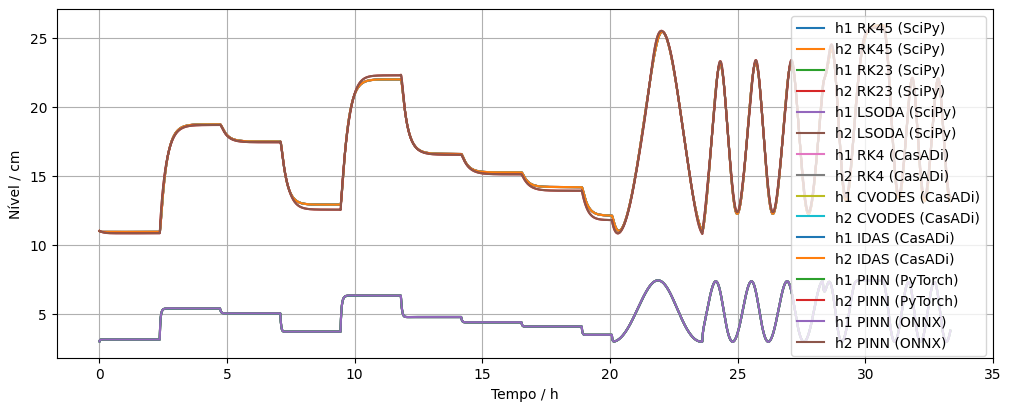

Retrieving measurements


In [8]:
import hickle as hkl

from lib.common_plots import plot_density
from lib.predict import predict_onnx
from lib.utils import timer


def test_pytorch(args):
    return predict_torch(*args, model=model, history_size=history_size)


def test_onnx(args):
    return predict_onnx(
        *args, pytorch_model=model, onnx_model=onnx_model, history_size=history_size
    )


methods = [
    ("RK45 (SciPy)", tanks.simulate_scipy, "RK45", []),
    ("RK23 (SciPy)", tanks.simulate_scipy, "RK23", []),
    ("LSODA (SciPy)", tanks.simulate_scipy, "LSODA", []),
    ("RK4 (CasADi)", tanks.simulate_casadi, "rk", []),
    ("CVODES (CasADi)", tanks.simulate_casadi, "cvodes", []),
    ("IDAS (CasADi)", tanks.simulate_casadi, "idas", []),
    ("PINN (PyTorch)", test_pytorch, (h1_cas, h2_cas, q_test_tensor), []),
    ("PINN (ONNX)", test_onnx, (h1_cas, h2_cas, q_test_tensor), []),
]

results = []
for method, func, arg, times in methods:
    (h1, h2), _ = timer(func, arg)
    results.extend([h1, h2])

# Graphical comparison
labels = []
for method in methods:
    labels.append(f"h1 {method[0]}")  # For h1
    labels.append(f"h2 {method[0]}")  # For h2

plot_tanks(tanks.t_numpy, results, labels)

# Measure multiple execution times
times = []

if os.path.isfile(benchmark_path):
    print("Retrieving measurements")
    times = hkl.load(benchmark_path)
else:
    print("Unable to retrieve measurements. Measuring again...")
    for _ in range(cf.benchmark_runs):
        for method, func, arg, times in methods:
            _, elapsed_time = timer(func, arg)
            times.append(elapsed_time)
    times = [method[3] for method in methods]
    hkl.dump(times, benchmark_path)

# Create benchmark image
plot_density(times, [method[0] for method in methods], f"{model_name}-benchmark")


In [9]:
from lib.common_plots import plot_boxplot

data = {
    "Métodos": ["RK45 (SciPy)"] * len(times[0])
    + ["RK23 (SciPy)"] * len(times[1])
    + ["LSODA (SciPy)"] * len(times[2])
    + ["RK4 (CasADi)"] * len(times[3])
    + ["CVODES (CasADi)"] * len(times[4])
    + ["IDAS (CasADi)"] * len(times[5])
    + ["PIRNN"] * len(times[7]),
    "Tempos": np.concatenate(
        [times[0], times[1], times[2], times[3], times[4], times[5], times[7]]
    ),
}

plot_boxplot(data, f"{model_name}-boxplot")
